<a href="https://colab.research.google.com/github/Madhukar-Palakaveeti/deep_learning/blob/main/neural_net_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [304]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [220]:
# @title Spiral dataset generation function
def generate_spiral_dataset(num_classes, num_samples_per_class, noise=0.2):
    X = []
    y = []

    for class_idx in range(num_classes):
        radius = np.linspace(0, 1, num_samples_per_class)
        theta = np.linspace(class_idx * 4, (class_idx + 1) * 4, num_samples_per_class) + np.random.randn(num_samples_per_class) * noise

        X_class = np.column_stack([radius * np.sin(theta), radius * np.cos(theta)])
        X.append(X_class)
        y.append(np.ones(num_samples_per_class, dtype= np.int64) * class_idx)

    X = np.vstack(X)
    y = np.hstack(y)

    return X, y

In [239]:
X_pre, y_pre = generate_spiral_dataset(3, 100)



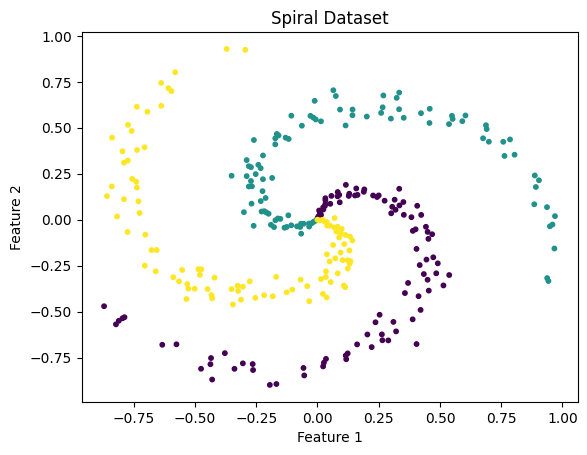

In [223]:
plt.scatter(X_pre[:, 0], X_pre[:, 1], c=y_pre, cmap='viridis', s=10)
plt.title('Spiral Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [224]:
data = np.concatenate((X_pre,y_pre[:, np.newaxis]), axis=1)
np.random.shuffle(data)
X = data[:, :-1]
y = data[:, -1].astype(np.int64)
print(y.dtype)



int64


In [225]:
# @title Train and Test splits
X_train = X[:210]
y_train = y[:210]
X_test = X[210:]
y_test = y[210:]


In [255]:
# @title Converting labels into one-hot encoded vectors for y_train
y_true = np.zeros((len(y_train), len(np.unique(y_train))), dtype=np.int64)
y_true[np.arange(len(y_train)), y_train] = 1
print(y_true.shape)

(210, 3)


In [302]:
# @title One-hot vectors for y_test
y_test_true = np.zeros((len(y_test), len(np.unique(y_test))), dtype=np.int64)
y_test_true[np.arange(len(y_test)), y_test] = 1
print(y_test_true.shape)

(90, 3)


In [248]:
# @title Neural Network
class Layer_Dense:
  def __init__(self,n_inputs,n_neurons):
    self.weights = 0.01 * np.random.randn(n_inputs,n_neurons)
    self.biases = np.zeros((1,n_neurons))

  def forward(self,inputs):
    self.output = np.dot(inputs, self.weights)+ self.biases

  def parameters(self):
    return self.weights

class Activation_ReLU:
  def forward(self,inputs):
    self.output = np.maximum(0,inputs)

class Activation_Softmax:
  def forward(self,inputs):
    exp_values = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
    probabilities = exp_values/np.sum(exp_values,axis=1,keepdims=True)
    self.output = probabilities


class Loss_Categoricalcrossentropy():
  def forward(self, probs, y_true):
    samples = len(probs)
    probs_clipped = np.clip(probs, 1e-7, 1 - 1e-7)
    #negative_log_likelihoods = -np.sum(y_true*np.log(probs_clipped))
    #final_loss = np.sum(negative_log_likelihoods)/samples
    correct_confidences = np.sum(probs_clipped * y_true, axis=1)
    n_l_l = -np.log(correct_confidences)
    final_loss = np.mean(n_l_l)
    return final_loss


In [249]:
# @title Creating the layers and activations
layer1 = Layer_Dense(2,64)
layer2 = Layer_Dense(64,32)
layer3 = Layer_Dense(32,3)
activation1 = Activation_ReLU()
activation2 = Activation_ReLU()
activation3 = Activation_Softmax()

In [387]:
# @title Forward Pass

layer1.forward(X_test[10])
activation1.forward(layer1.output)
a1 = activation1.output
print(a1.shape)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
a2 = activation2.output
print(a2.shape)
layer3.forward(activation2.output)
activation3.forward(layer3.output)
logits = activation3.output
print(logits.shape)

(1, 64)
(1, 32)
(1, 3)


In [383]:
# @title Calculating the loss and accuracy
loss_function = Loss_Categoricalcrossentropy()
loss = loss_function.forward(logits,y_test_true)
print(f"Loss : {loss}")

y_pred = np.argmax(activation3.output,axis=1)
accuracy = np.mean(y_pred == y_test)

print(f"Accuracy:{accuracy*100}")

Loss : 0.060449378707488
Accuracy:97.77777777777777


In [259]:
# @title BackPropogation
#getting the weights
w1 = layer1.weights
w2 = layer2.weights
w3 = layer3.weights
dw3 = a2.T @ (logits - y_true)
db3 = np.sum((logits - y_true),axis=0)
da2 = (logits - y_true) @ w3.T
dz2 = da2 * (a2 > 0)
dw2 = a1.T @ dz2
db2 = np.sum(dz2,axis=0)
da1 = dz2 @ w2.T
dz1 = da1 * (a1 > 0)
dw1 = X_train.T @ dz1
db1 = np.sum(dz1,axis=0)


In [260]:
# @title Gradient Descent
learning_rate = 0.001
layer1.weights -= learning_rate * dw1
layer2.weights -= learning_rate * dw2
layer3.weights -= learning_rate * dw3
layer1.biases -= learning_rate * db1
layer2.biases -= learning_rate * db2
layer3.biases -= learning_rate * db3

In [388]:
print(logits)
print(y_test[10])

[[4.34419549e-06 9.99995656e-01 1.51070552e-14]]
1


In [381]:
# @title Training loop
for i in range(1000):
  layer1.forward(X_train)
  activation1.forward(layer1.output)
  a1 = activation1.output

  layer2.forward(activation1.output)
  activation2.forward(layer2.output)
  a2 = activation2.output

  layer3.forward(activation2.output)
  activation3.forward(layer3.output)
  logits = activation3.output
  loss = loss_function.forward(logits,y_true)

  y_pred = np.argmax(activation3.output,axis=1)
  accuracy = np.mean(y_pred == y_train)

  w1 = layer1.weights
  w2 = layer2.weights
  w3 = layer3.weights
  dw3 = a2.T @ (logits - y_true)
  db3 = np.sum((logits - y_true),axis=0)
  da2 = (logits - y_true) @ w3.T
  dz2 = da2 * (a2 > 0)
  dw2 = a1.T @ dz2
  db2 = np.sum(dz2,axis=0)
  da1 = dz2 @ w2.T
  dz1 = da1 * (a1 > 0)
  dw1 = X_train.T @ dz1
  db1 = np.sum(dz1,axis=0)



  layer1.weights -= learning_rate * dw1
  layer2.weights -= learning_rate * dw2
  layer3.weights -= learning_rate * dw3
  layer1.biases -= learning_rate * db1
  layer2.biases -= learning_rate * db2
  layer3.biases -= learning_rate * db3
print(f"Loss : {loss}")
print(f"Accuracy:{accuracy*100}")

Loss : 0.0015127646822600848
Accuracy:100.0


In [330]:
# @title Storing weights
w1 = layer1.weights
w2 = layer2.weights
b1 = layer1.biases
b2 = layer2.biases
w3 = layer3.weights
b3 = layer3.biases
weights_dict = {
    'w1': w1,
    'w2': w2,
    'b1': b1,
    'b2': b2,
    'w3': w3,
    'b3': b3
}
np.save(open('weights.npy','wb'),weights_dict)
